# Linear models with Scikit-learn

In [152]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

## Boston

In [153]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [155]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm.score(X_test, y_test) # bounces around depending on test set

0.7326405218509042

In [156]:
x = [[0.03, 0, 7, 0, 0.47, 7.2, 61.1, 4.97, 2, 242, 17.8, 392, 4]]
lm.predict(x)

array([30.55190702])

In [157]:
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    print(lm.score(X_test, y_test))

0.767817050248177
0.7444277480186697
0.6192618870955926
0.5293441609521051
0.7664613721680568


In [158]:
# RF has more stable scores and generally better but linear model works well here
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(X_train, y_train)
    print(rf.score(X_test, y_test))

0.8857452881052088
0.7379694346704492
0.8919349920322079
0.8776966395934023
0.875621350548649


## NYC rent data set (Kaggle)

*Data use rules prevent us from storing this data in this repo*. Download the data
set from Kaggle. (You must be a registered Kaggle user and must be logged in.)
Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data)
and save `train.json`

In [159]:
def load_rent():
    df = pd.read_json('../../data/rent.json')

    # Create ideal numeric data set w/o outliers etc...
    df = df[(df.price > 1_000) & (df.price < 10_000)]
    df = df[df.bathrooms <= 4]  # There's almost no data for above with small sample
    df = df[(df.longitude != 0) | (df.latitude != 0)]
    df = df[(df['latitude'] > 40.55) & (df['latitude'] < 40.94) &
            (df['longitude'] > -74.1) & (df['longitude'] < -73.67)]
    df = df.sort_values('created')
    df_rent = df[['bedrooms', 'bathrooms', 'latitude', 'longitude', 'price']]

    return df_rent

In [160]:
df_rent = load_rent()
X = df_rent.drop('price', axis=1)
y = df_rent['price']
X.head()

,bedrooms,bathrooms,latitude,longitude
111817,1,1.0,40.7302,-73.9924
117995,0,1.0,40.7576,-73.9677
114617,3,2.0,40.7388,-73.9851
117474,1,1.0,40.7939,-73.9738
103891,1,1.0,40.7784,-73.9491


In [161]:
def score(X, y, model, n=10):
    train_scores = []
    test_scores = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        train_scores.append(train_score)
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)
    return np.mean(train_scores), np.mean(test_scores)

In [162]:
score(X, y, LinearRegression())

(0.5788505312553094, 0.5768352319295948)

### Random Forest much stronger than linear model

In [163]:
score(X, y, RandomForestRegressor(n_estimators=10), n=5)

(0.9428712978305315, 0.8533953621815309)

## Adding codependent and noise columns likely doesn't affect predictions

In [164]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [165]:
# Add columns with 1..n
for i in range(100):
    X[f'ID{i}'] = range(1,len(X)+1)
# dup some columns
X['CRIM2'] = X['CRIM']
X['AGE2'] = X['AGE']
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,ID92,ID93,ID94,ID95,ID96,ID97,ID98,ID99,CRIM2,AGE2
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,1,1,1,1,1,1,1,1,0.00632,65.2
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,2,2,2,2,2,2,2,2,0.02731,78.9
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,3,3,3,3,3,3,3,3,0.02729,61.1
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,4,4,4,4,4,4,4,4,0.03237,45.8
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,5,5,5,5,5,5,5,5,0.06905,54.2


In [166]:
score(X, y, LinearRegression())

(0.7392946619019578, 0.733820150373986)

## Plot residuals

Example: consumption of monthly food budget. When do we run out of pizza money?

In [167]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(1,n,num=n)
df['y'] = [500, 490, 487, 451, 434, 418, 401, 390, 376, 350]
df['y'] = df.y - df.x *2.5 - np.random.uniform(0,50,size=n)

(0, 500)

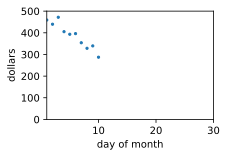

In [168]:
plt.figure(figsize=(3,2))
plt.scatter(df.x, df.y, s=5)
plt.xlabel('day of month')
plt.ylabel('dollars')
plt.xlim(1,30)
plt.ylim(0,500)

In [169]:
def mse(y,y_pred):
    return np.mean( (y - y_pred)**2 )

def line_fit(B, x):
    return B[2-1]*x + B[1-1]

def plot_residuals(x,y,B,xlabel,ylabel,line_xrange=None):
    fig, ax = plt.subplots(figsize=(4,2.5))
    ly = line_fit(B,x)
    ax.scatter(x, y, linewidth=.5, s=15)
    for c,d in zip(x,y):
        plt.plot([c,c],[line_fit(B,c),d], color='red', linewidth=.5)
    if line_xrange is not None:
        lx = np.arange(*line_xrange)
        gline, = plt.plot(lx,line_fit(B,lx),'--',color='grey', linewidth=1)
    else:
        gline, = plt.plot(x,ly,'--',color='grey', linewidth=1)
    loss = mse(ly, y)
    ax.text(17,350, f"Loss is {loss:.2f}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right',
            handles=[gline],
           labels=[f"Equation is $y = {B[0]:.1f} + {B[1]:.1f}x$"],
            fontsize=10)

(0, 500)

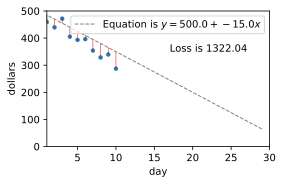

In [170]:
plot_residuals(df.x, df.y, [500,-15], xlabel='day', ylabel='dollars', line_xrange=(0,30))
plt.xlim(1,30)
plt.ylim(0,500)

(0, 500)

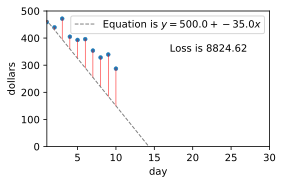

In [171]:
plot_residuals(df.x, df.y, [500,-35], xlabel='day', ylabel='dollars', line_xrange=(0,30))
plt.xlim(1,30)
plt.ylim(0,500)

(0, 500)

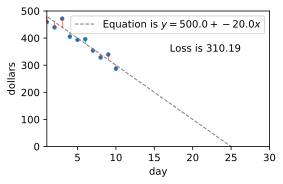

In [172]:
plot_residuals(df.x, df.y, [500,-20], xlabel='day', ylabel='dollars', line_xrange=(0,30))
plt.xlim(1,30)
plt.ylim(0,500)